# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

---
*From a business perspective, the client would like to maximize profits by understanding which columns in the dataset are most important to a car's final price. One approach to this problem is to train a multiple linear regression model on the data, then decompose the resulting curve into formulas describing each feature's effect on the price.*

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

---
Step 1: *Using the info() and value_counts() methods, one can get an idea of what information is available in the dataset.*

Step 2: *Graphs and/or statistical methods should be used to identify outliers in the numerical (price and year) columns.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
vehicles = pd.read_csv("data/vehicles.csv")

In [3]:
vehicles.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [4]:
vehicles_info = vehicles.info()
# in ascending order by non-null count:
# size, cylinders, condition, VIN, drive, paint_color, type, manufacturer, title_status, model, odometer, fuel, transmission, year, id/region/price/state

# we may be able to generate missing size values from the "type" column
# we might be able to generate various missing pieces of data from the models?
# cylinders, condition, drive, paint_color, type have a lot of missing values; perhaps an "unknown" column could be added? is that a terrible idea?
# VIN can just be removed; id can be used as the index?
# i'll probably rename "title_status" to just "status"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [5]:
# Here, I'll check out the contents of each column using the value_counts() method

#vehicles["id"].value_counts() #seems like every value is unique, so it CAN be used as an index if I want to for whatever reason
#vehicles["region"].value_counts() # Needs some string cleaning to make the format consistent? one-hot encoding
#vehicles["year"].value_counts() # Seems to have some outliers worth removing
#vehicles["manufacturer"].value_counts() # one-hot encoding
#vehicles["condition"].value_counts() # label encoding
#vehicles["model"].value_counts() # very inconsistent + i know nothing about cars, might be able to pull manufacturer names from it
#vehicles["cylinders"].value_counts() # Label encoding seems good, but "other" value makes that difficult
#vehicles["fuel"].value_counts() # one-hot encoding
#vehicles["odometer"].value_counts() # values here are confusing; are 1 and 0 binary somehow? may benefit from categorizing into groups, then label encoding
vehicles["title_status"].value_counts() # good from label encoding, if I can figure out what "lien" means, may mean a reposession?
#vehicles["transmission"].value_counts() # one-hot encoding
#vehicles["VIN"].value_counts() # seems useless to me; remove
#vehicles["drive"].value_counts() # one-hot encoding
#vehicles["size"].value_counts() # label encoding makes some sense here, but one-hot might be a better choice?
#vehicles["type"].value_counts() # one-hot encoding
#vehicles["paint_color"].value_counts() # one-hot encoding
#vehicles["state"].value_counts() # one-hot encoding; maybe replace state codes with names for readability?

title_status
clean         405117
rebuilt         7219
salvage         3868
lien            1422
missing          814
parts only       198
Name: count, dtype: int64

<Axes: xlabel='year', ylabel='Count'>

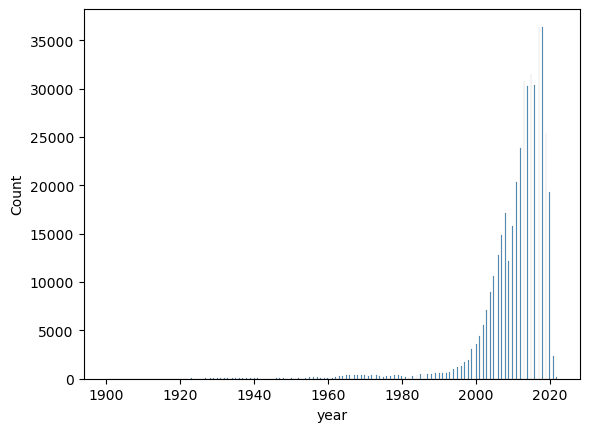

In [6]:
sns.histplot(vehicles["year"])
# looks like our data is skewed, but follows a relatively typical normal distribution

<Axes: xlabel='odometer', ylabel='Count'>

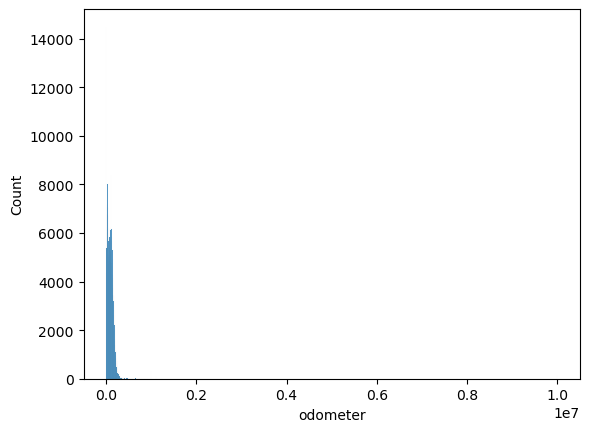

In [7]:
sns.histplot(vehicles["odometer"])
# oh boy, we've got outliers

In [8]:
# note: this never loads, so don't bother
# sns.histplot(vehicles["price"])

In [9]:
# time to look for outliers
numeric_columns = ["year", "odometer", "price"]
vehicles_z_scores = vehicles[numeric_columns].apply(lambda x: stats.zscore(x, nan_policy="omit"))
print(vehicles_z_scores)

            year  odometer     price
0            NaN       NaN -0.005680
1            NaN       NaN -0.005196
2            NaN       NaN -0.004449
3            NaN       NaN -0.006050
4            NaN       NaN -0.005771
...          ...       ...       ...
426875  0.821490 -0.307728 -0.004236
426876  0.927286 -0.402159 -0.003662
426877  0.927286 -0.438885 -0.003301
426878  0.715693 -0.317612 -0.003793
426879  0.821490 -0.352192 -0.003662

[426880 rows x 3 columns]


In [10]:
# Let's look at column with a z-score that has an absolute value greater than 3 and see how many outliers that gets us.
vehicles_outliers = vehicles_z_scores[lambda x: (abs(x) >= 3)]
vehicles_outliers.dropna(how="all")
# Looks like that will drop about 10,000 rows, mostly from "year"; not *too* bad

,year,odometer,price
101,-4.574132,NaN,NaN
137,-4.785725,NaN,NaN
208,-3.727760,NaN,NaN
210,-4.468335,NaN,NaN
228,-3.516167,NaN,NaN
...,...,...,...
426575,-4.362539,NaN,NaN
426593,-4.256742,NaN,NaN
426729,-6.372672,NaN,NaN
426762,-3.092981,NaN,NaN


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

---
Step 1: *Remove duplicated and useless columns and rows with too much missing data*

Step 2: *Attempt to generate missing data where appropriate*

Step 3: *Create placeholder values for everything else*

In [11]:
vehicles_clean = vehicles.drop("id", axis=1) # useless column
vehicles_clean = vehicles_clean.drop("VIN", axis=1) # another useless column to drop

# remove duplicate rows
print(vehicles_clean.shape)
vehicles_clean = vehicles_clean.drop_duplicates()
print(vehicles_clean.shape)

# drop rows with outliers
vehicles_z_scores = vehicles_clean[numeric_columns].apply(lambda x: stats.zscore(x, nan_policy="omit"))
vehicles_clean = vehicles_clean[vehicles_z_scores[lambda x: (abs(x) >= 3)].any(axis=1) == False]

(426880, 16)
(370465, 16)


In [12]:
# import car model dictionary
make_model_table = pd.read_csv("https://raw.githubusercontent.com/arthurkao/vehicle-make-model-data/refs/heads/master/csv_data.csv")
make_model_table.value_counts()

year  make                model    
2001  ACURA               CL           1
2010  MERCEDES-BENZ       CL600        1
                          E350         1
                          E300         1
                          CLS63 AMG    1
                                      ..
2006  AMERICAN IRONHORSE  OUTLAW       1
                          LSC          1
                          LEGEND       1
      ALFA ROMEO          147          1
2016  VOLVO               XC90         1
Name: count, Length: 19772, dtype: int64



---



In [13]:
# only keep necessary data from the imported table, and make sure everything is lowercase in both tables for easier regex matching later
make_model_table["make"] = make_model_table["make"].str.lower()
make_model_table["model"] = make_model_table["model"].str.lower()

vehicles_clean["manufacturer"] = vehicles_clean["manufacturer"].str.lower()
manufacturer_list = vehicles_clean["manufacturer"].unique()

make_model_table = make_model_table[make_model_table["make"].isin(manufacturer_list)].drop("year", axis=1)
make_model_table

,make,model
0,acura,cl
1,acura,el
2,acura,integra
3,acura,mdx
4,acura,nsx
...,...,...
19766,volvo,xc70
19768,kia,sorento
19769,mazda,6
19770,mazda,cx-5


In [14]:
# let's turn this table into something (debatably) more useful

make_list = make_model_table["make"].unique()

# Why use a dictionary when you intend to iterate over it, you may ask? Good question!
make_model_dict = {}

for make in make_list:
    make_model_dict[make] = make_model_table[make_model_table["make"] == make]["model"].unique()

make_model_dict

{'acura': array(['cl', 'el', 'integra', 'mdx', 'nsx', 'rl', 'tl', 'rsx', 'tsx',
        'csx', 'rdx', 'zdx', 'ilx', 'rlx', 'tlx'], dtype=object),
 'audi': array(['a3', 'a4', 'a4 quattro', 'a6', 'a6 quattro', 'a8 quattro',
        'allroad quattro', 's3', 's4', 's6', 's8', 'tt', 'tt quattro',
        'rs4', 'rs6', 'a3 quattro', 'q7', 'a5', 'a5 quattro', 'r8', 's5',
        'q5', 'a1', 'rs5', 'a7 quattro', 'a4 allroad', 'allroad', 'q3',
        's7', 'rs7', 'sq5', 'a8', 'q3 quattro'], dtype=object),
 'bmw': array(['320i', '323i', '325ci', '325i', '325xi', '330ci', '330i', '330xi',
        '525i', '530i', '540i', '740i', '740il', '750il', 'f650 enduro',
        'f650cs', 'f650gs', 'f650gs abs', 'f650gs dakar', 'k1200lt',
        'k1200ltc', 'k1200lti icon', 'k1200rs', 'm3', 'm5', 'r1100rl',
        'r1100rs abs', 'r1100rt', 'r1100s', 'r1100sa', 'r1150gs', 'r1150r',
        'r1150rs', 'r1150rt', 'r1200c', 'r1200c avantgarde',
        'r1200c classic', 'r1200c euro', 'r1200c independent',
 

In [15]:
# The code below was run to generate the new vehicles_clean dataset that gets loaded.
# Since it took a while to run, I saved the generated table and will load it next rather than force anyone running this to regenerate the data.

# We'll need regexes for this one.
#import re

# now to fill in missing values in the manufacturer column by comparing the make column with the model strings
#for index in make_model_table.index:
#  model_string = make_model_table["model"][index]
#  # please find it in your heart to forgive me
#  for make in make_model_dict.keys():
#    if re.search("\b" + make + "\b", model_string):
#      vehicles_clean["manufacturer"][index] = make
#    else:
#      for model in make_model_dict[make]:
#        if re.search("\b" + model + "\b", model_string):
#          vehicles_clean["manufacturer"][index] = make

#vehicles_clean.to_csv('data/vehicles_with_model_to_manufacturer.csv', index=False)

In [16]:
vehicles_clean = pd.read_csv("data/vehicles_with_model_to_manufacturer.csv")
vehicles_clean

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361189,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,fwd,NaN,sedan,NaN,wy
361190,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,fwd,NaN,sedan,red,wy
361191,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,NaN,NaN,hatchback,white,wy
361192,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,fwd,NaN,sedan,silver,wy


In [17]:
# we don't need the model column anymore, so let's drop it
vehicles_clean = vehicles_clean.drop("model", axis=1)
vehicles_clean.shape

(361194, 15)

In [18]:
# Now, let's drop rows that are more than half missing.
vehicles_clean.dropna(thresh=len(vehicles_clean.columns)/2, inplace=True)
vehicles_clean.shape

(360524, 15)

In [19]:
# rather than removing anything else, let's replace missing values with "unknown" for the rest of the data
nonnumeric_columns = ["region", "manufacturer", "condition", "cylinders", "fuel", "title_status", "transmission", "drive", "size", "type", "paint_color", "state"]

# wait, this line actually works??
vehicles_clean[nonnumeric_columns] = vehicles_clean[nonnumeric_columns].fillna("unknown")

In [20]:
# for numeric columns, let's fill in the missing values with numbers
numeric_columns = ["year", "odometer", "price"]

# the internet tells me this will use column means, not table means...
vehicles_clean[numeric_columns] = vehicles_clean[numeric_columns].fillna(vehicles_clean[numeric_columns].mean())

In [21]:
# now we need to encode all this categorical data
# why is it all one-hot encoding? so I can keep the "unknown" values without assigning them a value, and because I'm not sure label encoding will be useful here
vehicles_clean = pd.get_dummies(vehicles_clean, columns=["region", "manufacturer", "condition", "cylinders", "fuel", "title_status", "transmission", "drive", "size", "type", "paint_color", "state"])
vehicles_clean

,price,year,odometer,region_SF bay area,region_abilene,region_akron / canton,region_albany,region_albuquerque,region_altoona-johnstown,region_amarillo,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
19,33590,2014.0,57923.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20,22590,2010.0,71229.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
21,39590,2020.0,19160.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
22,30990,2017.0,41124.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
23,15000,2013.0,128000.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361189,23590,2019.0,32226.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
361190,30590,2020.0,12029.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
361191,34990,2020.0,4174.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
361192,28990,2018.0,30112.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [23]:
# with 569 columns, generating features is just too much for my computer
# besides, it will be much easier to interpret the results with just one weight for each column

# initial unfit ridge model
scaled_ridge_model = Pipeline([
	#("my_transform", PolynomialFeatures(degree=2,include_bias=False)),
	("scale", StandardScaler()),
	("my_regression", Ridge())
])

# initial unfit lasso model
scaled_lasso_model = Pipeline([
	#("my_transform", PolynomialFeatures(degree=2,include_bias=False)),
	("scale", StandardScaler()),
	("my_regression", Lasso())
])

In [24]:
parameters_to_try = {"my_regression__alpha": 10**np.linspace(-2,4,50)}
model_finder = GridSearchCV(estimator = scaled_ridge_model,
	param_grid = parameters_to_try,
	scoring = "neg_mean_squared_error",
	cv = 5)

model_finder.fit(vehicles_clean.drop("price", axis=1), vehicles_clean["price"])
best_ridge_model = model_finder.best_estimator_

In [71]:
#best_ridge_model.named_steps["my_regression"].coef_

In [29]:
model_finder.best_params_

{'my_regression__alpha': 7543.120063354608}

In [30]:
model_finder.best_score_
# I genuinely do not know how to interpret this value.

-4066293533.0714273

In [34]:
coefficients_table = pd.DataFrame(zip(vehicles_clean.drop("price", axis=1).columns, best_ridge_model.named_steps["my_regression"].coef_))
coefficients_table.sort_values(by=1)

,0,1
1,odometer,-3550.754728
467,fuel_gas,-1214.884660
500,type_sedan,-1035.128320
483,drive_fwd,-1016.336345
459,cylinders_4 cylinders,-1010.633546
...,...,...
462,cylinders_8 cylinders,1189.078974
417,manufacturer_ferrari,1289.719263
211,region_mcallen / edinburg,1311.899157
465,fuel_diesel,2342.950377


In [35]:
coefficients_table.to_csv('data/coefficients_table.csv', index=False)

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [52]:
coefficients_table[coefficients_table[0].str.contains("condition")].sort_values(by=1)

,0,1
455,condition_unknown,-305.985668
449,condition_excellent,-261.436505
454,condition_salvage,-64.305777
453,condition_new,119.672393
451,condition_good,302.971829
452,condition_like new,307.671698
450,condition_fair,379.839296


In [48]:
coefficients_table[coefficients_table[0].str.contains("cylinders")]

,0,1
456,cylinders_10 cylinders,386.301169
457,cylinders_12 cylinders,756.764513
458,cylinders_3 cylinders,-160.376138
459,cylinders_4 cylinders,-1010.633546
460,cylinders_5 cylinders,-132.972864
461,cylinders_6 cylinders,112.285422
462,cylinders_8 cylinders,1189.078974
463,cylinders_other,-251.335256
464,cylinders_unknown,-229.479094


In [53]:
coefficients_table[coefficients_table[0].str.contains("drive")].sort_values(by=1)

,0,1
483,drive_fwd,-1016.336345
485,drive_unknown,-191.335861
484,drive_rwd,95.657830
482,drive_4wd,1070.396748


In [54]:
coefficients_table[coefficients_table[0].str.contains("fuel")].sort_values(by=1)

,0,1
467,fuel_gas,-1214.884660
468,fuel_hybrid,-346.491073
469,fuel_other,-327.749406
466,fuel_electric,-288.476005
470,fuel_unknown,24.020179
465,fuel_diesel,2342.950377


In [55]:
coefficients_table[coefficients_table[0].str.contains("manufacturer")].sort_values(by=1)

,0,1
437,manufacturer_nissan,-748.570603
427,manufacturer_kia,-631.544973
423,manufacturer_hyundai,-583.090554
435,manufacturer_mitsubishi,-498.815418
447,manufacturer_volkswagen,-487.927974
416,manufacturer_dodge,-424.568623
414,manufacturer_chrysler,-357.818428
443,manufacturer_subaru,-316.543675
431,manufacturer_mazda,-314.002622
418,manufacturer_fiat,-266.650156


In [62]:
coefficients_table[coefficients_table[0] == "odometer"]

,0,1
1,odometer,-3550.754728


In [63]:
coefficients_table[coefficients_table[0].str.contains("paint_color")].sort_values(by=1)

,0,1
515,paint_color_unknown,-532.041616
514,paint_color_silver,-177.315765
507,paint_color_brown,-46.152575
511,paint_color_orange,4.921540
513,paint_color_red,29.409845
517,paint_color_yellow,39.355284
506,paint_color_blue,44.073862
510,paint_color_grey,49.866394
512,paint_color_purple,89.069770
516,paint_color_white,106.187003


In [64]:
coefficients_table[coefficients_table[0].str.contains("region")].sort_values(by=1)

,0,1
298,region_salem,-471.968442
198,region_long island,-413.773979
98,region_el paso,-274.948266
156,region_inland empire,-270.040653
58,region_chicago,-250.999523
...,...,...
4,region_akron / canton,419.597561
257,region_olympic peninsula,453.181855
402,region_youngstown,739.930291
208,region_mansfield,875.507874


In [65]:
coefficients_table[coefficients_table[0].str.contains("size")].sort_values(by=1)

,0,1
487,size_full-size,-228.128177
486,size_compact,-207.858181
488,size_mid-size,-198.045690
489,size_sub-compact,-91.363413
490,size_unknown,414.265093


In [66]:
coefficients_table[coefficients_table[0].str.contains("state")].sort_values(by=1)

,0,1
545,state_nc,-293.526869
563,state_va,-260.060543
542,state_mo,-186.832033
520,state_ar,-155.179440
555,state_or,-153.025875
552,state_ny,-146.553487
537,state_ma,-102.643210
539,state_me,-89.159671
556,state_pa,-88.511851
558,state_sc,-87.021577


In [67]:
coefficients_table[coefficients_table[0].str.contains("title_status")].sort_values(by=1)

,0,1
476,title_status_salvage,-269.895394
477,title_status_unknown,-153.499531
474,title_status_parts only,-149.313667
473,title_status_missing,-100.934460
475,title_status_rebuilt,-41.223284
472,title_status_lien,199.272890
471,title_status_clean,208.577165


In [68]:
coefficients_table[coefficients_table[0].str.contains("transmission")].sort_values(by=1)

,0,1
478,transmission_automatic,-584.021102
481,transmission_unknown,26.322427
479,transmission_manual,232.283040
480,transmission_other,508.619624


In [69]:
coefficients_table[coefficients_table[0].str.contains("type")].sort_values(by=1)

,0,1
500,type_sedan,-1035.128320
495,type_hatchback,-726.025749
491,type_SUV,-543.447572
504,type_wagon,-352.587313
492,type_bus,-156.301838
496,type_mini-van,-62.334727
497,type_offroad,78.619628
503,type_van,141.155230
502,type_unknown,235.739347
498,type_other,304.445047


In [70]:
coefficients_table[coefficients_table[0] == "year"]

,0,1
0,year,4741.357033


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

### Overall, the best-selling cars are new cars, Ferraris, and diesel-powered vehicles.

Condition seems to have little effect on sale value, and my data seems to indicate cars in fair condition sell the most. I would take this as an indication that the data or training methods are not ideal, rather than at face value.

8-cylinder cars sell for the most, 4-cylinders the least.

Front-wheel drive sells for less than four-wheel drive, with rear-wheel drive in the middle.

Diesel cars sell for significantly more than other fuel types, and gas-powered vehicles significantly less.

Ferraris sell for a lot, followed by Porsches and Teslas. Nissans, Kias, and Hyundais sell for the least.
Black cars sell for the most money, followed by custom colors. Overall, color has little impact on price.

Cars from  the McAllen/Edinburg, Texas sell for the most, followed by cars from Mansfield, Georgia. Salem and Long Island sell for the least. My guess regarding this is that these locations are more southern and rural, and thus call for larger vehicles that can drive longer distances, possibly capable of offroad driving.

Very little information can be gained from the size category.

Cars sell for the most in the Idaho, Texas, and Florida categories, and least in North Carolina, Virginia, and Missouri. My guess is there's some balancing between cost of living in the area and the need to drive long distances (sprawl).

Status has minor impact, but clean cars sell the most, and salvage the least.

Transmission is another minimal impact category. Automatics sell for the least, and "other" sells for the most.

Pickups sell for significantly more than other cars, followed distantly by coupes and trucks. Sedans sell for significantly less, followed by hatchbacks and SUVs.

Year has the most impact of all on price, about twice as much as the next most important factor, whether on not the car uses diesel fuel.